## Getting all paths from the graph

In [148]:
from collections import deque

class TemporalGraph:
    def __init__(self):
        self.nodes = set()
        self.graph = nx.DiGraph()

    def add_edge(self, u, v, t):
        self.nodes.add(u)
        self.nodes.add(v)
        self.graph.add_edge(u, v, timestamp=t)

    def get_edges_greater_than_time(self, node, t):
        neighbors = []
        for neighbor, edge_data in self.graph[node].items():
            if edge_data['timestamp'] > t:
                neighbors.append((neighbor, edge_data['timestamp']))
        return neighbors
    
    def get_nodes(self):
        return list(self.nodes)

In [149]:
def bfs_temporal_paths(graph, start_node, max_path_len=None):
    queue = deque([[(start_node, -float('inf'))]])
    all_paths = []

    while queue:
        path = queue.popleft()
        current_node, current_time = path[-1]

        neighbors = graph.get_edges_greater_than_time(current_node, current_time)

        if not neighbors or (max_path_len is not None and len(path) >= max_path_len):
            all_paths.append(path)
            continue

        for next_node, next_time in neighbors:
            new_path = path + [(next_node, next_time)]
            queue.append(new_path)

    return all_paths

In [150]:
from test import read_data

reddit_edges = read_data('reddit')

In [151]:
temporal_graph = TemporalGraph()

for u, v, t in reddit_edges:
    temporal_graph.add_edge(u, v, t)

In [152]:
from concurrent.futures import ThreadPoolExecutor

all_paths_for_all_nodes = []

with ThreadPoolExecutor(max_workers=12) as executor:
    futures = {
        node: executor.submit(bfs_temporal_paths, temporal_graph, node) 
        for node in temporal_graph.get_nodes()
    }

    for node, future in futures.items():    
        try:
            node_paths = future.result()
            all_paths_for_all_nodes += node_paths
        except Exception as e:
            print(f"Error processing node {node}: {e}")

In [153]:
paths = [[node for node, time in path] for path in all_paths_for_all_nodes]

In [154]:
path_lens = [len(path) for path in paths]

In [155]:
import numpy as np

min(path_lens), max(path_lens), np.mean(path_lens), np.median(path_lens)

(2, 17, 7.101817890648165, 7.0)

## Training skip-gram from the paths

In [174]:
from gensim.models import Word2Vec

str_paths = [[str(node) for node in walk] for walk in paths]
embedding_model = Word2Vec(
    vector_size=128, epochs=10, window=10, 
    min_count=1, sg=1, workers=6
)

embedding_model.build_vocab(str_paths)
embedding_model.train(str_paths, total_examples=len(str_paths), epochs=embedding_model.epochs)

(229189549, 325503940)

In [175]:
def get_embedding_for_all_nodes(embedding_model):
    return {int(node): embedding_model.wv[node] for node in embedding_model.wv.index_to_key}

In [176]:
embedding_dict = get_embedding_for_all_nodes(embedding_model)

## Compute interaction count graph

In [177]:
import pandas as pd

df = pd.DataFrame(reddit_edges, columns=['u', 'i', 't'])

df['pair'] = df.apply(lambda row: tuple(sorted([row['u'], row['i']])), axis=1)
interaction_counts = df['pair'].value_counts()
interaction_dict = interaction_counts.to_dict()

## Plotting the embedding vs interaction count (euclidean distance)

In [178]:
import random
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import spearmanr, pearsonr

def validate_embeddings(embedding_dict, interaction_dict, distance_method):
    random.seed(42)
    filtered_pairs = [(i, j) for i, j in interaction_dict.keys() if i != j]
    
    similarities = []
    interaction_counts = []
    
    for i, j in filtered_pairs:
        if distance_method == 'euclidean':
            sim = euclidean(embedding_dict[i], embedding_dict[j])
        elif distance_method == 'cosine':
            sim = cosine(embedding_dict[i], embedding_dict[j])
        else:
            raise Exception("Invalid distance_method")
            
        similarities.append(sim)
        
        interaction_counts.append(interaction_dict[(i, j)])
    
    pearson_corr, _ = pearsonr(similarities, interaction_counts)
    spearman_corr, _ = spearmanr(similarities, interaction_counts)
    
    return similarities, interaction_counts, pearson_corr, spearman_corr

In [179]:
distances_euclidean, interaction_counts_euclidean, pearson_corr_euclidean, spearman_corr_euclidean = validate_embeddings(
    embedding_dict, interaction_dict, 'euclidean'
)

In [180]:
print(f"Pearson Correlation: {pearson_corr_euclidean}")
print(f"Spearman Correlation: {spearman_corr_euclidean}")

Pearson Correlation: 0.05630164541199563
Spearman Correlation: 0.11997168751688851


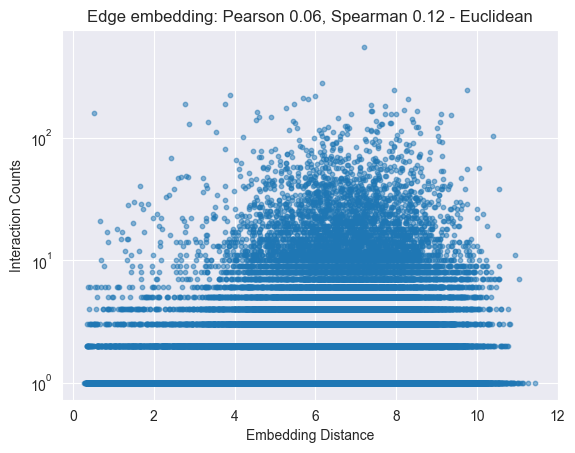

In [181]:
import matplotlib.pyplot as plt

plt.scatter(distances_euclidean, interaction_counts_euclidean, alpha=0.5, s=10)
plt.title(f"Edge embedding: Pearson {pearson_corr_euclidean:.2f}, Spearman {spearman_corr_euclidean:.2f} - Euclidean")
plt.xlabel("Embedding Distance")
plt.ylabel("Interaction Counts")
plt.yscale('log')
plt.grid(True)
plt.savefig('plots/edge_embedding_skipgram.png')
plt.show()

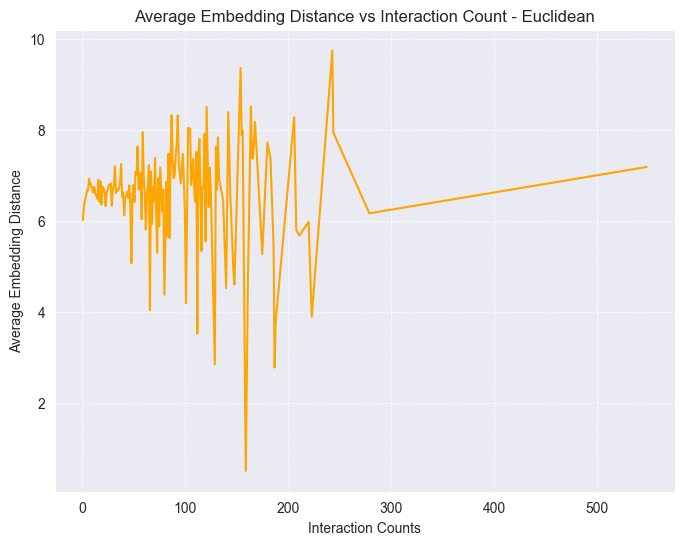

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

distance_by_interaction = defaultdict(list)

for distance, interaction in zip(distances_euclidean, interaction_counts_euclidean):
    distance_by_interaction[interaction].append(distance)

interaction_counts = sorted(distance_by_interaction.keys())
average_distances = [
    np.mean(distance_by_interaction[interaction]) for interaction in interaction_counts
]

plt.figure(figsize=(8, 6))
plt.plot(interaction_counts, average_distances, color='orange', linewidth=1.5, label='Average Trend')

plt.title("Average Embedding Distance vs Interaction Count - Euclidean")
plt.xlabel("Interaction Counts")
plt.ylabel("Average Embedding Distance")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.savefig('plots/average_embedding_distance_per_interaction.png')
plt.show()


## Plotting the embedding vs interaction count (cosine distance)

In [183]:
distances_cosine, interaction_counts_cosine, pearson_corr_cosine, spearman_corr_cosine = validate_embeddings(
    embedding_dict, interaction_dict, 'cosine'
)

In [184]:
print(f"Pearson Correlation: {pearson_corr_cosine}")
print(f"Spearman Correlation: {spearman_corr_cosine}")

Pearson Correlation: 0.06339963143906506
Spearman Correlation: 0.12879302864241168


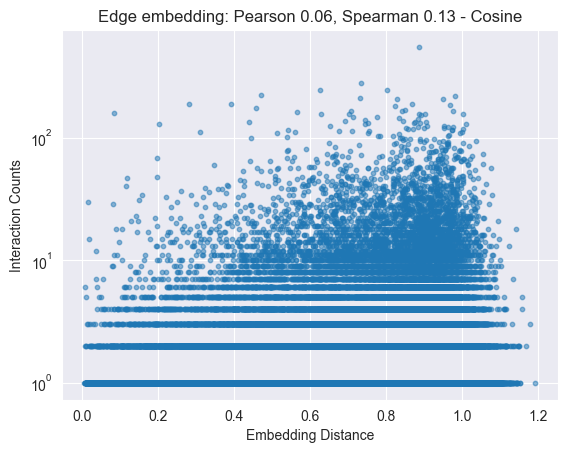

In [185]:
import matplotlib.pyplot as plt

plt.scatter(distances_cosine, interaction_counts_cosine, alpha=0.5, s=10)
plt.title(f"Edge embedding: Pearson {pearson_corr_cosine:.2f}, Spearman {spearman_corr_cosine:.2f} - Cosine")
plt.xlabel("Embedding Distance")
plt.ylabel("Interaction Counts")
plt.yscale('log')
plt.grid(True)
plt.savefig('plots/edge_embedding_skipgram.png')
plt.show()

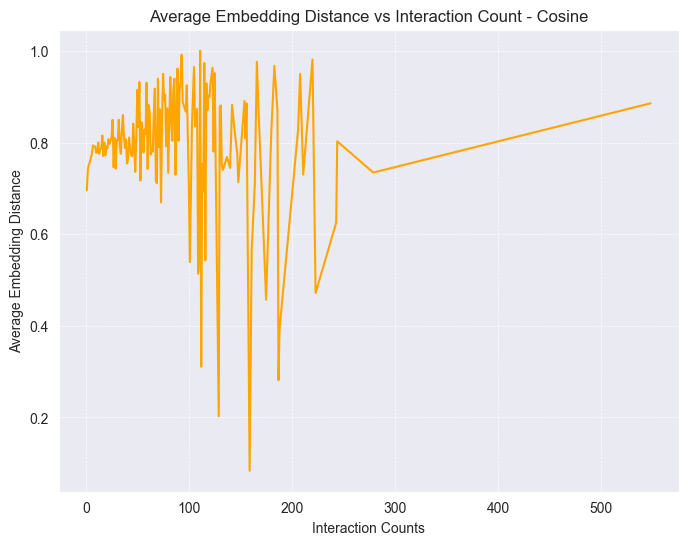

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

distance_by_interaction = defaultdict(list)

for distance, interaction in zip(distances_cosine, interaction_counts_cosine):
    distance_by_interaction[interaction].append(distance)

interaction_counts = sorted(distance_by_interaction.keys())
average_distances = [
    np.mean(distance_by_interaction[interaction]) for interaction in interaction_counts
]

plt.figure(figsize=(8, 6))
plt.plot(interaction_counts, average_distances, color='orange')

plt.title("Average Embedding Distance vs Interaction Count - Cosine")
plt.xlabel("Interaction Counts")
plt.ylabel("Average Embedding Distance")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.savefig('plots/average_embedding_distance_per_interaction.png')
plt.show()

## Some more analysis

#### Prepare node counts

In [187]:
upstream_counts = {}
downstream_counts = {}
node_counts = {}

for u, i, t in reddit_edges:
    upstream_counts[u] = upstream_counts.get(u, 0) + 1
    downstream_counts[i] = downstream_counts.get(i, 0) + 1
    
    node_counts[u] = node_counts.get(u, 0) + 1
    node_counts[i] = node_counts.get(i, 0) + 1

#### Sort node counts

In [188]:
sorted_node_counts = sorted(node_counts.items(), key=lambda item: -item[1])

In [189]:
import networkx as nx

G = nx.Graph()

for u, i, t in reddit_edges:
    G.add_edge(u, i)

#### Word2Vec Most Similar Nodes Plots

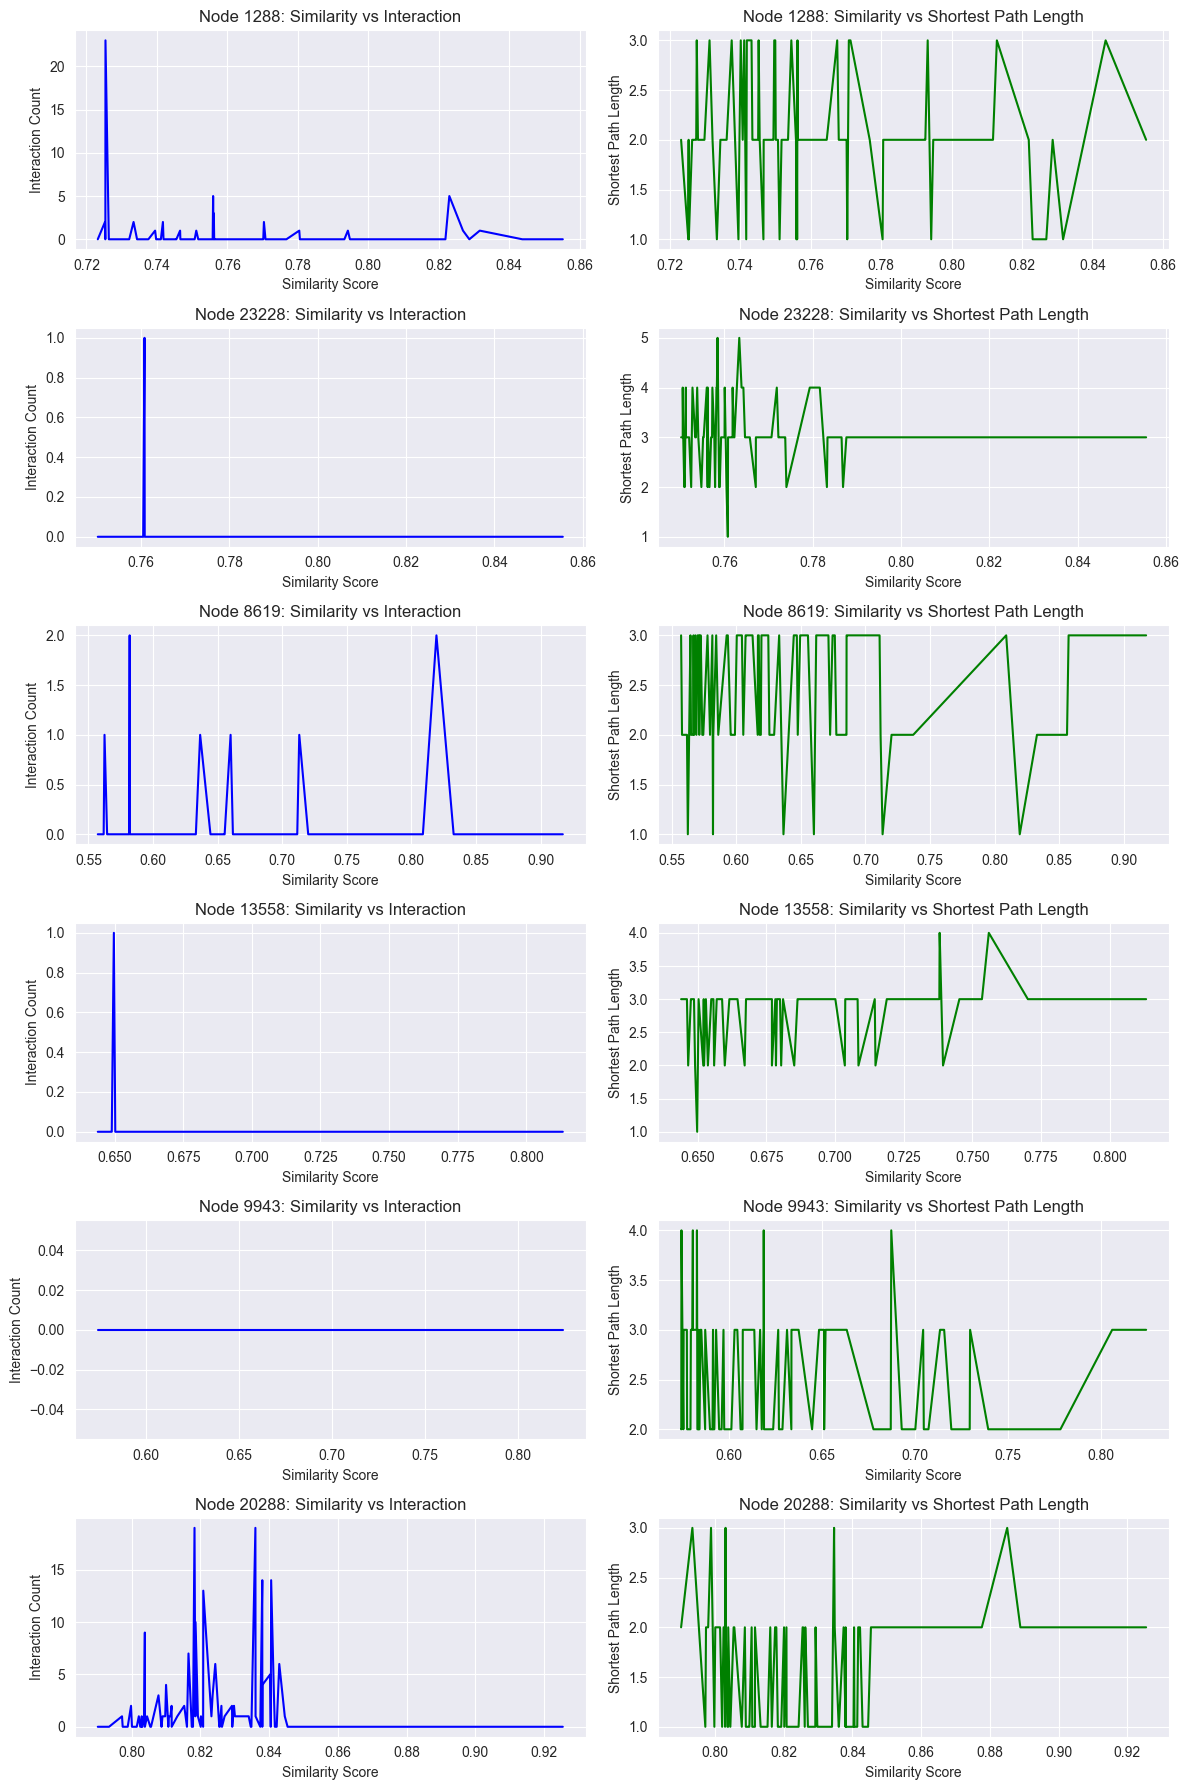

In [206]:
import matplotlib.pyplot as plt
import networkx as nx

fig, axes = plt.subplots(6, 2, figsize=(12, 18))  # 6 rows, 2 columns

for i in range(6):
    current_node = sorted_node_counts[i][0]
    most_similars = embedding_model.wv.most_similar(positive=current_node, topn=100)

    similarity_scores = []
    interaction_counts = []
    shortest_path_lengths = []

    for most_similar, similarity_score in most_similars:
        most_similar_node = int(most_similar)
        dict_key = tuple(sorted([current_node, most_similar_node]))
        
        interaction_count = interaction_dict.get(dict_key, 0)
        shortest_path_len = nx.shortest_path_length(G, source=current_node, target=most_similar_node)
        
        similarity_scores.append(similarity_score)
        interaction_counts.append(interaction_count)
        shortest_path_lengths.append(shortest_path_len)

    ax1 = axes[i, 0]
    ax1.plot(similarity_scores, interaction_counts, color='blue', label='Interaction Count')
    ax1.set_title(f"Node {current_node}: Similarity vs Interaction")
    ax1.set_xlabel("Similarity Score")
    ax1.set_ylabel("Interaction Count")
    ax1.grid(True)

    ax2 = axes[i, 1]
    ax2.plot(similarity_scores, shortest_path_lengths, color='green', label='Shortest Path Length')
    ax2.set_title(f"Node {current_node}: Similarity vs Shortest Path Length")
    ax2.set_xlabel("Similarity Score")
    ax2.set_ylabel("Shortest Path Length")
    ax2.grid(True)

plt.tight_layout()
plt.show()